1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.


 2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [ ]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn import datasets

In [ ]:
# Отображение таблиц полостью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# глобальные константы
N_SAMPLES = 1000
N_FEATCHES = 2
N_CLASSES = 2
N_TREES = [1, 3, 5, 10]
QUALITY_TYPES = {0: 'Неопределенность Джини',
                 1: 'Энтропия Шеннона',
                 2: 'Ошибка классификации',
                 3: 'Дисперсия (регрессия)'}


In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( \
    n_samples = N_SAMPLES, n_features = N_FEATCHES, n_informative = N_FEATCHES, \
    n_classes = N_CLASSES, n_redundant=0, n_clusters_per_class=1, random_state=13)

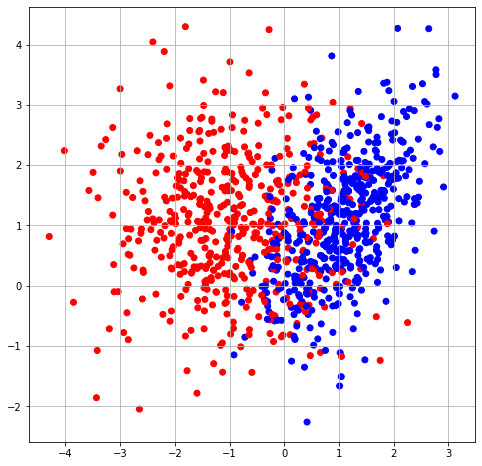

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), \
            list(map(lambda x: x[1], classification_data)), \
            c=classification_labels, cmap=colors)
plt.grid(True)

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict(type_quality = 0)
        
    def predict(self, type_quality = 0):

        if type_quality < 3:
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1
            #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
            prediction = max(classes, key=classes.get)
        else:
            # print('classes:', type(classes),len(classes),classes)
            prediction = np.mean(data)
        return prediction        



---



In [ ]:
random.seed(42)

def get_bootstrap_and_oob(data, labels, n_subsamples):
    # функция для генерации подвыборок с помощью бутстрэпа,
    # а также остальных индексов подвыборок (реализация Out-of-Bag)
    # в отличие от предыдущей версии get_bootstrap0, где labels[indices].astype(np.float64)
    # здесь labels[indices].astype(np.int64), что дает прирост скорости выполнения
    # метода random_forest на n_trees=5 ~ 55 сек против ~ 2 мин 15 сек (get_bootstrap0)
    n_samples = data.shape[0]
    n_featches = data.shape[1]
    indices = np.random.randint(0, len(data) - 1, (n_subsamples, len(data)))

    # формирование невошедших индексов в бутстрэп для Out-of-Bag (вместо тестовых данных)
    oob_indices_ = np.array(([get_unsample_indices(row, len(data)) for row in indices]))

    # приведение строк к одинаковому размеру для объединения
    # строки неодинакового размера получаются из-за уникальности индексов при разности set

    # определение максимального размера из всех строк
    max_col = np.max([row.shape[0] for row in oob_indices_])
    oob_indices = np.zeros((oob_indices_.shape[0], max_col), dtype=np.int64)
    _row = 0
    for row in oob_indices_:
        oob_indices[_row] = row[0]
        oob_indices[_row, :row.shape[0]] = row
        _row += 1

    bootstrap = list(map(lambda a, b: (a.reshape(n_samples, n_featches), b.flatten()), \
                      np.split(data[indices], n_subsamples), \
                      np.split(labels[indices], n_subsamples)))
    oob = list(map(lambda a, b: (a.reshape(oob_indices.shape[1], n_featches), b.flatten()), \
                      np.split(data[oob_indices], n_subsamples), \
                      np.split(labels[oob_indices], n_subsamples)))
    return bootstrap, oob

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, n_subsamples):
    # функция для генерации подвыборок с помощью бутстрэпа
    # в отличие от предыдущей версии get_bootstrap0, где labels[indices].astype(np.float64)
    # здесь labels[indices].astype(np.int64), что дает прирост скорости выполнения
    # метода random_forest на n_trees=5 ~ 55 сек против ~ 2 мин 15 сек (get_bootstrap0)
    n_samples = data.shape[0]
    n_featches = data.shape[1]
    indices = np.random.randint(0, len(data) - 1, (n_subsamples, len(data)))
    bootstrap = list(map(lambda a, b: (a.reshape(n_samples, n_featches), b.flatten()), \
                      np.split(data[indices], n_subsamples), \
                      np.split(labels[indices], n_subsamples)))
    return bootstrap

In [ ]:
# Сохранение случайных индексов подвыборки (для признаков N_FEATCHES!!!)
# т.е. len_sample = data.shape[1]
random.seed(42)

def get_subsample_indices(len_sample, type_quality = 0):

    if type_quality < 3: # задача классификации
        len_subsample = int(np.sqrt(len_sample))
    else: # задача регрессии
        len_subsample = int(len_sample / 3)

    subsample_indices = set()
    while len(subsample_indices) < len_subsample:
        subsample_indices.add(random.randint(0, len_sample - 1))

    return list(subsample_indices)

In [ ]:
# Создание неиспользованных индексов подвыборки (Out-of-Bag)
random.seed(42)

def get_unsample_indices(subsample_indices, len_sample):

    # формирование строки с оставшимися индексами
    all_indices = {x for x in range(len_sample)}
    unsample_indices = list(all_indices.difference(subsample_indices))
    np.random.shuffle(unsample_indices)
    return np.array(unsample_indices)

In [ ]:
# УДАЛИТЬ
data = np.array([[0,1],
                 [2,3],
                 [4,5],
                 [6,7],
                 [8,9],
                 [10,11],
                 [12,13],
                 [14,15],
                 [16,17],
                 [18,19],
                 [20,21],
                 [22,23],
                 [24,25],
                 [26,27],
                 [28,29],
                 [30,31],
                 [32,33],
                 [34,35],
                 [36,37],
                 [38,39],
                 [40,41],
                 [42,43],
                 [44,45],
                 [46,47],
                 [48,49],
                 [50,51],
                 [52,53],
                 [54,55],
                 [56,57],
                 [58,59]])
labels = np.array([1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0,1])
print(data.shape, labels.shape)

bootstrap, oob = get_bootstrap_and_oob(data, labels, 3)
print('bootstrap:',bootstrap)
print('\n\noob:',oob)

(30, 2) (30,)
bootstrap: [(array([[34, 35],
       [26, 27],
       [ 2,  3],
       [26, 27],
       [28, 29],
       [18, 19],
       [40, 41],
       [ 2,  3],
       [12, 13],
       [52, 53],
       [16, 17],
       [ 0,  1],
       [ 0,  1],
       [24, 25],
       [38, 39],
       [32, 33],
       [46, 47],
       [ 6,  7],
       [20, 21],
       [38, 39],
       [ 2,  3],
       [ 2,  3],
       [10, 11],
       [32, 33],
       [42, 43],
       [16, 17],
       [42, 43],
       [ 8,  9],
       [ 6,  7],
       [46, 47]]), array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1])), (array([[50, 51],
       [10, 11],
       [34, 35],
       [28, 29],
       [50, 51],
       [38, 39],
       [30, 31],
       [ 2,  3],
       [32, 33],
       [52, 53],
       [36, 37],
       [18, 19],
       [18, 19],
       [ 4,  5],
       [50, 51],
       [10, 11],
       [36, 37],
       [28, 29],
       [30, 31],
       [20, 21],
       [48, 4

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчет критерия энтропии Шеннона 

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= (p * np.log2(p))
        
    return entropy

In [ ]:
# Расчет критерия ошибки классификации (misclassification error) 

def missclass(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    missclass_err = 1 - max(P)
        
    return missclass_err

In [ ]:
# Расчет критерия для регрессии - дисперсия
# РАБОТАЕТ НЕ ВЕРНО!!!!

def var(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    var = np.array(P).var()

    return var

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, prev_quality, type_quality = 0):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if type_quality == 0:
        left_koef = gini(left_labels)
        right_koef = gini(right_labels)
    elif type_quality == 1:
        left_koef = entropy(left_labels)
        right_koef = entropy(right_labels)
    elif type_quality == 2:
        left_koef = missclass(left_labels)
        right_koef = missclass(right_labels)
    else:# РАБОТАЕТ НЕ ВЕРНО!!!!
        left_koef = var(left_labels)
        right_koef = var(right_labels)
        
    return prev_quality - p * left_koef - (1 - p) * right_koef

In [ ]:
# Расчет логистической функции потерь для подсчета Out_of_Bag

def calc_logloss(y, y_pred):
    y_pred_ = np.array(y_pred, dtype = np.float64)
    y_pred_[y_pred_ < 1e-9] = 1e-9
    y_pred_[y_pred_ > .9999999999999999] = .9999999999999999
    err = - np.mean(y * np.log(y_pred_) + (1.0 - y) * np.log(1.0 - y_pred_))
    return err

In [ ]:
# Расчет MSE - функции потерь для подсчета Out_of_Bag

def mean_squared_error(y, y_pred):
    return sum((y - y_pred)**2) / len(y)
    y_pred_ = np.array(y_pred, dtype = np.float64)
    y_pred_[y_pred_ < 1e-9] = 1e-9
    y_pred_[y_pred_ > .9999999999999999] = .9999999999999999
    err = - np.mean(y * np.log(y_pred_) + (1.0 - y) * np.log(1.0 - y_pred_))
    return err

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, type_quality = 0):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    if type_quality == 0:
        prev_quality = gini(labels)
    elif type_quality == 1:
        prev_quality = entropy(labels)
    elif type_quality == 2:
        prev_quality = missclass(labels)
    else:
        prev_quality = var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample_indices = get_subsample_indices(n_features, type_quality)
    # print('1.subsample_indices:',subsample_indices)
    # print('1.data.shape:',data.shape)
    # print('1.n_features:',n_features)
    # print('1.type_quality:',type_quality)

    for index in subsample_indices:

        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, prev_quality, type_quality)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index, subsample_indices

In [ ]:
# Построение дерева с помощью рекурсивной функции
# Критерии останова: количество листьев, количество используемых признаков, глубина дерева

def build_tree(data, labels, type_quality = 0, tree_level = 1, max_tree_level = 20000, max_leaf_count = 50000):

    global leaf_count
    # print('data:', data)
    # print('labels:', labels)

    quality, t, index, subsample_indices = find_best_split(data, labels, type_quality)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества,
    #  Или когда уровень вложенности равен максимальному,
    #  Или когда общее количество листов больше или равно максимальному
    if quality == 0 or tree_level == max_tree_level or leaf_count >= max_leaf_count:
        leaf_count += 2
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    tree_level += 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, type_quality, tree_level)
    false_branch = build_tree(false_data, false_labels, type_quality, tree_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def random_forest(data, labels, n_trees, type_quality):
    
    # Получение бутстрапа - случайных подвыборок labels
    # print('get_bootstrap(data, labels, n_trees):',get_bootstrap(data, labels, n_trees) )
    bootstrap, oob = get_bootstrap_and_oob(data, labels, n_trees) # новая версия с labels[indices].astype(np.int64)
    # print('2.bootstrap:',bootstrap)
    _row = 0
    oob_err = 0
    forest = []
    print('--------------------------------------')
    for b_data, b_labels in bootstrap:
        # print('2.b_data:',type(b_data),b_data.shape)
        # print('2.b_labels:',type(b_labels),b_labels.shape)
        # print('2.b_data:',b_data)
        # Получение дерева
        tree = build_tree(b_data, b_labels, type_quality)

        # Реализация Out-of-Bag
        # выбор неиспользуемого индекса из (Out-of-Bag)

        # print('2.oob[_row][0]:',type(oob[_row][0]),oob[_row][0])
        # print('2.oob[_row][1]:',type(oob[_row][1]),oob[_row][1])
        # tree_vote_oob(tree, oob[_row][0])

        # предсказание созданного дерева (Out-of-Bag)
        predictions = predict(oob[_row][0], tree, type_quality)

        #
        # oob_err += calc_logloss(oob[_row][1], predictions)
        oob_err += mean_squared_error(oob[_row][1], predictions)
        
        print(f'{_row}. oob_err: {oob_err:.3f}')
        # print('2.b_data.shape:',b_data.shape)
        # print('2.b_data:',b_data)
        # print('2.unsample_indices:',unsample_indices)
        # # print('2.n_features:',n_features)


        # print('tree.sample_indices:',tree.sample_indices)
        # print('data[unsample_indices]:',data[unsample_indices])

        # train_data = 
        # # Получим ответы от Out-of-Bag
        # oob_prediction = predict(train_data, tree)

        # Добавлем дерево в лес
        forest.append(tree)

        _row += 1

        # Очистка накопленных при обучении индексы из подвыборок для текущего дерева
        # tree.sample_indices.clear()


        
    return forest, oob_err

In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node, type_quality = 0):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.predict(type_quality)
        return answer

    # print('4.obj[node.index]:',type(obj[node.index]),obj[node.index])
    # print('4.node.t:',node.t)
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree, type_quality = 0):
    
    # print('5.data:',type(data),data.shape, data)
    classes = [classify_object(obj, tree, type_quality) for obj in data]
    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = [predict(data, tree) for tree in forest]
    # print('7.predictions:',len(predictions[0]),type(predictions),predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # print('7.predictions_per_object:',len(predictions_per_object),type(predictions_per_object),predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
    # print('7.voted_predictions:',len(voted_predictions),type(voted_predictions),voted_predictions)
        
    return voted_predictions

In [ ]:
# УДАЛИТЬ!!!
# предсказание голосованием дерева (реализация Out-of-Bag)

def tree_vote_oob(tree, data):

    # добавим предсказания дерева в список
    predictions = [predict(data, tree)]

    # print('6.predictions:',len(predictions[0]),type(predictions),predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # print('6.predictions_per_object:',len(predictions_per_object),type(predictions_per_object),predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
    # print('6.voted_predictions:',len(voted_predictions),type(voted_predictions),voted_predictions)
        
    return voted_predictions

In [ ]:
# Метод получения метрик качества
# Нужен подключенный Numpy as np: import numpy as np
def quality_metrics(y_true, y_predict, get_metrics = '*', bin_threshold = 0.5):
    # get_metrics = '*' - получение всех метрик: accuracy, matrix_errors, precision, recall, F_score
    # get_metrics = 'a'/'accuracy' - получение accuracy
    # get_metrics = 'm'/'matrix_errors' - получение matrix_errors
    # get_metrics = 'p'/'precision' - получение precision
    # get_metrics = 'r'/'recall' - получение recall
    # get_metrics = 'f'/'f_score' - получение f_score
    # get_metrics = 'tp' - получение TP
    # get_metrics = 'tn' - получение TN
    # get_metrics = 'fn' - получение FN
    # get_metrics = 'fp' - получение FP

    metrics = {}
    y = np.array(y_true)
    y_pred = np.array(y_predict)

    TP = ((y > bin_threshold) & (y_pred > bin_threshold)).sum()
    TN = ((y <= bin_threshold) & (y_pred <= bin_threshold)).sum()
    FN = ((y > bin_threshold) & (y_pred <= bin_threshold)).sum()
    FP = ((y <= bin_threshold) & (y_pred > bin_threshold)).sum()

    # accuracy - доля правильных ответов
    accuracy = (TP + TN) / y.shape[0]

    # матрица ошибок
    matrix_errors = np.array([[TP, FP],[FN, TN]])

    # precision
    precision = TP / (TP + FP)

    # recall
    recall = TP / (TP + FN)

    # recall
    f_score =  2 * precision * recall / (precision + recall)

    for m in get_metrics.split(','):
        m = m.strip()
        if m == '*':
            metrics['accuracy'] = accuracy
            metrics['matrix_errors'] = matrix_errors
            metrics['precision'] = precision
            metrics['recall'] = recall
            metrics['f_score'] = f_score
            break
        elif m == 'a' or m == 'accuracy':
            metrics['accuracy'] = accuracy
        elif m == 'm' or m == 'matrix_errors':
            metrics['matrix_errors'] = matrix_errors
        elif m == 'p' or m == 'precision':
            metrics['precision'] = precision
        elif m == 'r' or m == 'recall':
            metrics['recall'] = recall
        elif m == 'f' or m == 'f_score':
            metrics['f_score'] = f_score
        elif m == 'tp':
            metrics['TP'] = TP
        elif m == 'tn':
            metrics['TN'] = TN
        elif m == 'fn':
            metrics['FN'] = FN
        elif m == 'fp':
            metrics['FP'] = FP

    return metrics

In [ ]:
# Распечатка метрик качества разбиения
def print_metrics(labels, data, n_trees, type_sample, type_quality):
    metrics = quality_metrics(labels, data)

    if type_sample == 0:
        print(f"\nМетрики качества случайного леса из {n_trees} деревьев на обучающей выборке")
    else:
        print(f"\nnМетрики качества случайного леса из {n_trees} деревьев на тестовой выборке")
    if type_quality == 0:
        print("с критерием качества разбиения неопределенности Джини:")
    elif type_quality == 1:
        print("с критерием качества разбиения энтропией Шеннона:")
    elif type_quality == 2:
        print("с критерием качества разбиения ошибкой классификации:")
    else:
        print("с критерием качества разбиения дисперсией (для регрессии):")
    print(f"accuracy={metrics['accuracy']:.3f}")
    print(f"matrix_errors:\n{metrics['matrix_errors']}")
    print(f"precision={metrics['precision']:.3f}")
    print(f"recall={metrics['recall']:.3f}")
    print(f"F_score={metrics['f_score']:.3f}")

In [ ]:
# Распечатка oob-ошибки (Out-of-Bag)
def print_oob_error(oob_error, n_trees, type_quality):

    print(f"\nОшибка Out-of-Bag случайного леса из {n_trees} деревьев на Out-of-Bag-выборке")
    if type_quality == 0:
        print("с критерием качества разбиения неопределенности Джини:")
    elif type_quality == 1:
        print("с критерием качества разбиения энтропией Шеннона:")
    elif type_quality == 2:
        print("с критерием качества разбиения ошибкой классификации:")
    else:
        print("с критерием качества разбиения дисперсией (для регрессии):")
    print(f"oob_error={oob_error:.3f}")


In [ ]:
# Накопление метрик качества разбиения
def get_metrics(labels, data, n_trees, type_sample, type_quality):
    metrics = quality_metrics(labels, data)
    metrics[f'accuracy_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('accuracy', '-')
    metrics[f'matrix_errors_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('matrix_errors', '-')
    metrics[f'precision_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('precision', '-')
    metrics[f'recall_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('recall', '-')
    metrics[f'f_score_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('f_score', '-')
    return metrics



---





Начало работы



In [ ]:
# УДАЛИТЬ ЯЧЕЙКУ!!!
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = \
    model_selection.train_test_split(classification_data, \
                                     classification_labels, \
                                     test_size = 0.3, \
                                     random_state = 1)

In [ ]:
# Построим случайные леса из {N_TREES} деревьев по обучающей и тестовой выборкам
# с различными критериями качества разбиения

# Результаты работы
data_table = []

for n_trees in N_TREES:

    for type_quality in range(4):

        # Текущее значение общего количества листов
        leaf_count = 0

        # Построим случайный лес из {n_trees} деревьев и {type_quality} критерием качества разбиения
        my_forest, oob_err = random_forest(classification_data, classification_labels, n_trees, type_quality)

        print_oob_error(oob_err, n_trees, type_quality)

--------------------------------------
0. oob_err: 0.219

Ошибка Out-of-Bag случайного леса из 1 деревьев на Out-of-Bag-выборке
с критерием качества разбиения неопределенности Джини:
oob_error=0.219
--------------------------------------
0. oob_err: 0.151

Ошибка Out-of-Bag случайного леса из 1 деревьев на Out-of-Bag-выборке
с критерием качества разбиения энтропией Шеннона:
oob_error=0.151
--------------------------------------
0. oob_err: 0.159

Ошибка Out-of-Bag случайного леса из 1 деревьев на Out-of-Bag-выборке
с критерием качества разбиения ошибкой классификации:
oob_error=0.159
--------------------------------------
0. oob_err: 844.142

Ошибка Out-of-Bag случайного леса из 1 деревьев на Out-of-Bag-выборке
с критерием качества разбиения дисперсией (для регрессии):
oob_error=844.142
--------------------------------------
0. oob_err: 0.220
1. oob_err: 0.418
2. oob_err: 0.653

Ошибка Out-of-Bag случайного леса из 3 деревьев на Out-of-Bag-выборке
с критерием качества разбиения неопред